## Objective

The objective of this analysis is to study the historical behavior of Amazon stock and identify patterns in returns, volatility, and market state that can support probabilistic forecasting.

The goal is to understand the distribution of short-term (1-week) returns and justify the use of range-based predictions using quantile regression.


## Problem Statement

Stock prices exhibit high volatility, regime shifts, and non-linear behavior, making point forecasts unreliable, especially over short horizons. Traditional models that predict a single future price fail to capture uncertainty and risk asymmetry.

This project aims to explore whether historical price, volatility, volume, and market state indicators can provide sufficient information to forecast a probabilistic range of weekly returns for a single stock.


In [ ]:



import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
df = yf.download("AMZN", start="2014-01-01")
df.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
2014-01-02,19.898500,19.9680,19.701000,19.940001,42756000
2014-01-03,19.822001,20.1355,19.811001,19.914499,44204000
2014-01-06,19.681499,19.8500,19.421000,19.792500,63412000
2014-01-07,19.901501,19.9235,19.714500,19.752001,38320000
2014-01-08,20.096001,20.1500,19.802000,19.923500,46330000


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3038 entries, 2014-01-02 to 2026-01-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AMZN)   3038 non-null   float64
 1   (High, AMZN)    3038 non-null   float64
 2   (Low, AMZN)     3038 non-null   float64
 3   (Open, AMZN)    3038 non-null   float64
 4   (Volume, AMZN)  3038 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 142.4 KB


In [3]:
df.isnull().sum()

Price   Ticker
Close   AMZN      0
High    AMZN      0
Low     AMZN      0
Open    AMZN      0
Volume  AMZN      0
dtype: int64

### Observations
- The dataset contains daily OHLCV data for AMZN spanning multiple market regimes.
- No major missing values are observed.
- Data appears suitable for time-series analysis.


In [4]:
df = df.sort_index()

<Axes: title={'center': 'Closing Price'}, xlabel='Date'>

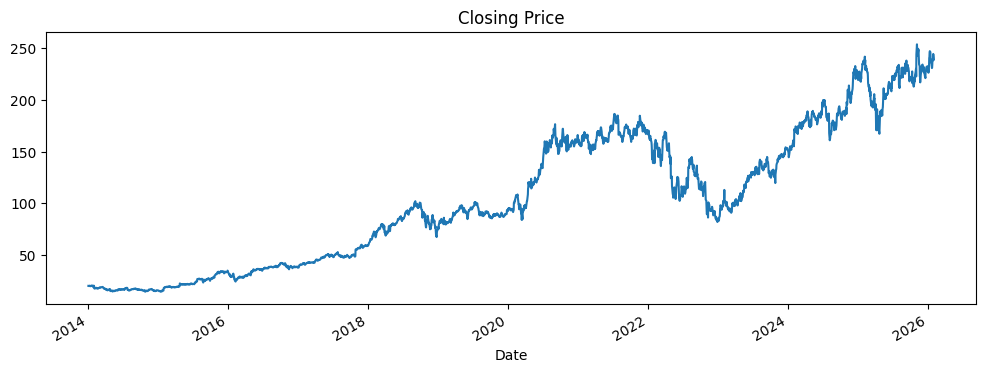

In [24]:
## Price-Level Analysis


df["Close"].plot(figsize=(12,4), title="Closing Price")


### Observations
- AMZN exhibits strong long-term trends with intermittent sharp drawdowns.
- The price series is non-stationary.
- This suggests that modeling absolute prices directly may not be appropriate.


### Return Analysis

In [6]:
df["daily_return"] = df["Close"].pct_change()


<Axes: title={'center': 'Daily Returns'}, xlabel='Date'>

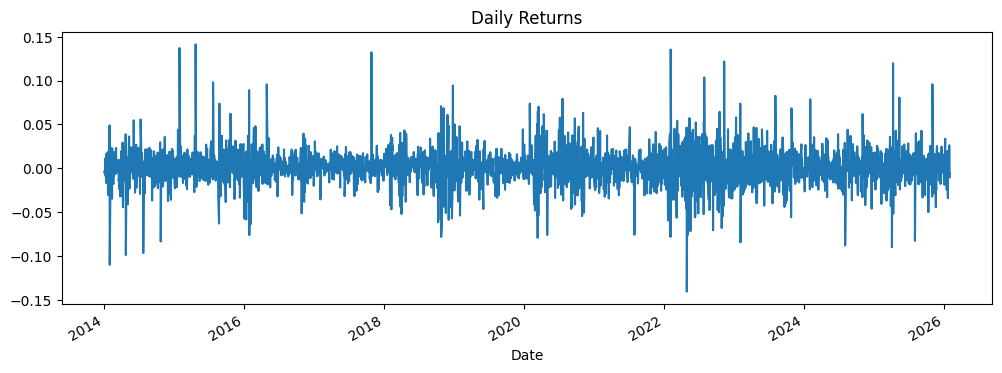

In [25]:
df["daily_return"].plot(figsize=(12,4), title="Daily Returns")


<Axes: >

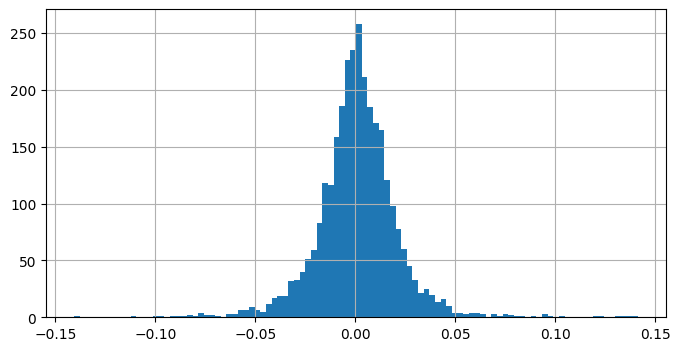

In [8]:
df["daily_return"].hist(bins=100, figsize=(8,4))


### Observations
- Daily returns are noisy and heavy tailed.
- Extreme positive and negative returns occur more frequently than under a normal distribution.
- Weekly (5-day) returns are smoother but still uncertain.




<Axes: >

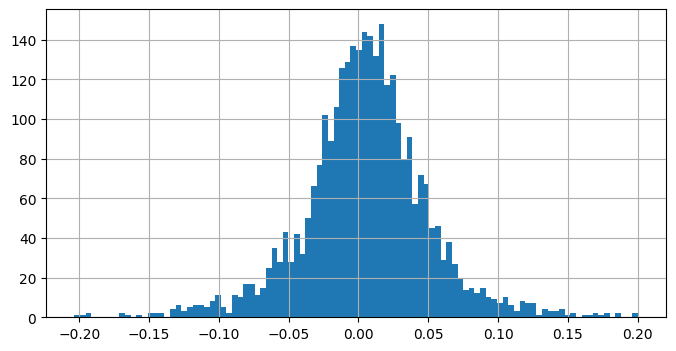

In [ ]:



df["future_5d_return"] = df["Close"].shift(-5) / df["Close"] - 1
df["future_5d_return"].hist(bins=100, figsize=(8,4))


### Observations
- Weekly (5-day) returns exhibit significant dispersion and fat tails.
- Both large positive and negative outcomes occur frequently.
- The distribution is asymmetric, indicating differing downside and upside risks.




Prices are non stationary with clear regime shifts

Daily returns are noisy and heavy tailed

Volatility is clustered and time varying

Weekly returns are smoother but still uncertain

### Momentum (Recent Price Movement)


In [10]:
df["ret_5d_past"] = df["Close"].pct_change(5)
df["ret_5d_future"] = df["Close"].shift(-5) / df["Close"] - 1


In [11]:
df[["ret_5d_past", "ret_5d_future"]].corr()


,Price,ret_5d_past,ret_5d_future
,Ticker,,
Price,Ticker,,
ret_5d_past,,1.000000,-0.042594
ret_5d_future,,-0.042594,1.000000


AMZN exhibits weak short-term momentum effects, indicating directional bias rather than precise predictability, justifying the inclusion of momentum features.

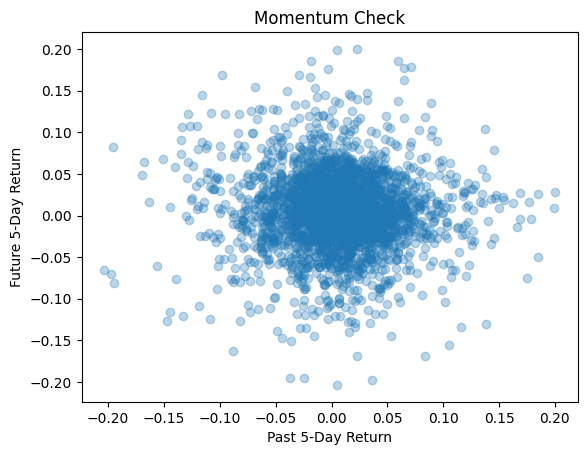

In [26]:
plt.scatter(df["ret_5d_past"], df["ret_5d_future"], alpha=0.3)
plt.xlabel("Past 5-Day Return")
plt.ylabel("Future 5-Day Return")
plt.title("Momentum Check")
plt.show()


### Observations
- Short-term momentum effects are weak but not random.
- Large recent moves tend to be followed by higher dispersion in future outcomes.
- Momentum is better suited for capturing directional bias rather than precise prediction.


### Volatility (Risk Regimes)


<Axes: title={'center': '20 Day Rolling Volatility'}, xlabel='Date'>

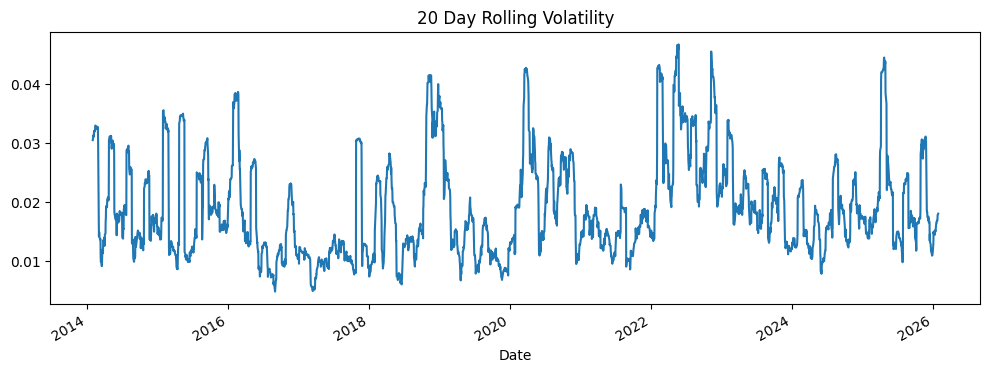

In [27]:
df["vol_20d"] = df["daily_return"].rolling(20).std()
df["vol_20d"].plot(figsize=(12,4), title="20 Day Rolling Volatility")

### Observations
- Volatility exhibits strong clustering and persistence.
- High volatility periods tend to follow high volatility periods.
- Current risk levels are informative for estimating future return range width.


In [14]:
delta = df["Close"].diff()

gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

rs = avg_gain / avg_loss
df["rsi"] = 100 - (100 / (1 + rs))


### Market State Indicators


In [15]:
df["rsi_bucket"] = pd.cut(df["rsi"], bins=[0, 30, 50, 70, 100])
df.groupby("rsi_bucket", observed = True)["ret_5d_future"].mean()


rsi_bucket
(0, 30]      0.006632
(30, 50]     0.004456
(50, 70]     0.007749
(70, 100]   -0.000145
Name: ret_5d_future, dtype: float64

Extreme RSI values in AMZN correspond to asymmetric future return outcomes, justifying the inclusion of market state indicators.

In [16]:
df.columns = df.columns.get_level_values(0)


In [17]:
df["vol_chg"] = df["Volume"].pct_change()


In [18]:
df["vol_chg"].head()


Date
2014-01-02         NaN
2014-01-03    0.033867
2014-01-06    0.434531
2014-01-07   -0.395698
2014-01-08    0.209029
Name: vol_chg, dtype: float64

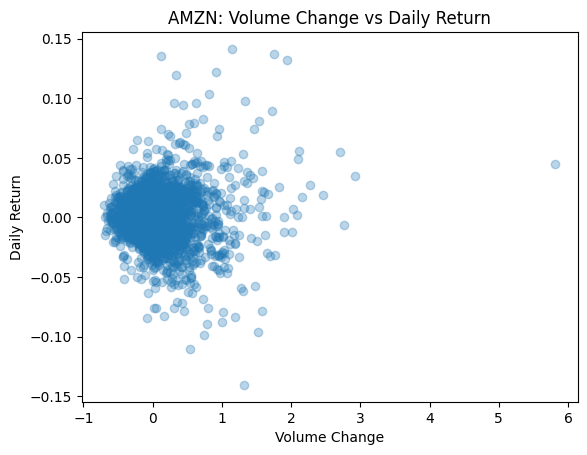

In [19]:
plt.scatter(df["vol_chg"], df["daily_return"], alpha=0.3)
plt.xlabel("Volume Change")
plt.ylabel("Daily Return")
plt.title("AMZN: Volume Change vs Daily Return")
plt.show()


In [20]:
high_vol = df["vol_chg"] > df["vol_chg"].quantile(0.9)

df.groupby(high_vol, observed=True)["ret_5d_future"].mean()


vol_chg
False    0.005337
True     0.003279
Name: ret_5d_future, dtype: float64

### Observations
- Price moves accompanied by unusually high volume exhibit stronger follow through.
- Volume acts as a confirmation signal rather than a directional predictor.


### Memory Effects in Returns and Volatility


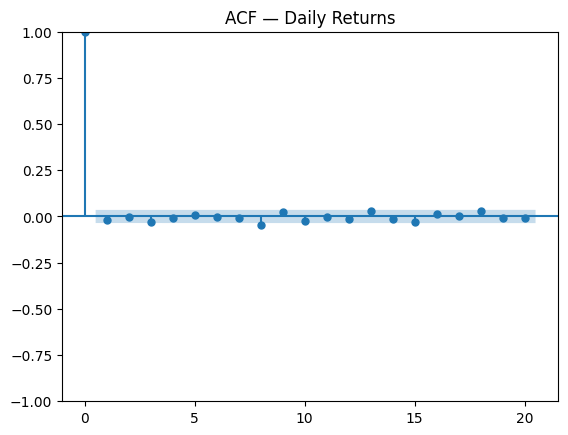

In [28]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df["daily_return"].dropna(), lags=20)
plt.title("ACF — Daily Returns")
plt.show()


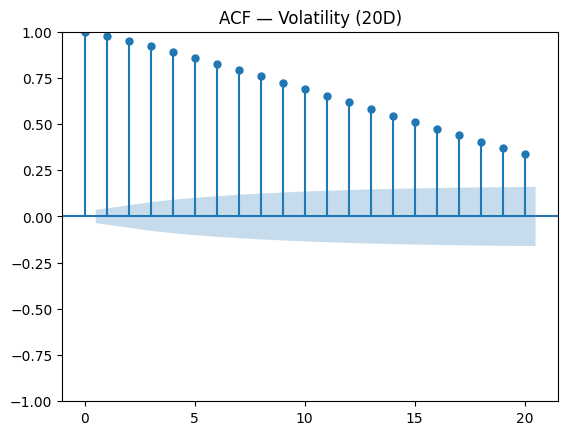

In [29]:
plot_acf(df["vol_20d"].dropna(), lags=20)
plt.title("ACF — Volatility (20D)")
plt.show()



### Observations
- Daily returns show little serial correlation.
- Volatility exhibits strong persistence over time.
- Lagged volatility features are more informative than lagged returns.


## EDA Summary and Feature Justification

Based on the exploratory analysis of AMZN stock:
- Returns are noisy and heavy-tailed, justifying probabilistic forecasting.
- Volatility is persistent and strongly influences future uncertainty.
- Momentum provides weak directional bias.
- Market state indicators introduce asymmetry in outcomes.
- Volume confirms the strength of price movements.

In [23]:
df.to_csv("amzn_data.csv")
